<a href="https://colab.research.google.com/github/Imjiram/Proyecto_Equipo-46/blob/main/Avance_5_46.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROYECTO INTEGRADOR


# **Avance 5. Modelo final

Jiram Cesar Villalpando Guerrero        A01793579

Josep Romagosa Llordén                  A01374637

José Francisco Muñoz Del Angel          A01794174


---



3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.




In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
from google.colab import drive
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import dask.dataframe as dd
import warnings
import pandas as pd
import time
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import Parallel, delayed

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
file_path = '/content/drive/MyDrive/MNA/Proyecto Final/Collab/data_source/'


csv_files = ['data8.csv', 'data9.csv', 'data10.csv']  # Solo 3 archivos

# Leer archivos CSV y combinarlos en un DataFrame
dfs = [pd.read_csv(file_path + file) for file in csv_files]
data = pd.concat(dfs, ignore_index=True)

In [76]:
df = data[['CourierCode', 'Parcel', 'ZipCodeFrom', 'ZipCodeTo', 'TransitAt', 'DeliveredAt']]

In [77]:
df['ParcelDict'] = df['Parcel'].apply(json.loads)
df['Weight'] = df['ParcelDict'].apply(lambda x: x.get('Weight', 0))
df['Height'] = df['ParcelDict'].apply(lambda x: x.get('Height', 0))
df['Length'] = df['ParcelDict'].apply(lambda x: x.get('Length', 0))
df['Width'] = df['ParcelDict'].apply(lambda x: x.get('Width', 0))
df.drop(['Parcel', 'ParcelDict'], axis=1, inplace=True)

In [78]:
# Convertir columnas de fecha
df['TransitAt'] = pd.to_datetime(df['TransitAt'])
df['DeliveredAt'] = pd.to_datetime(df['DeliveredAt'])

In [79]:
# Calculo de tiempo en transito
df['TransitTime'] = (df['DeliveredAt'] - df['TransitAt']).dt.total_seconds() / 3600

In [80]:
# Transformación logaritmica de TransitTime para normalizar la distribucion
df['TransitTime_log'] = np.log1p(df['TransitTime'])

In [81]:
# Añadir caracteristicas basadas en la fecha
df['TransitAt_year'] = df['TransitAt'].dt.year
df['TransitAt_month'] = df['TransitAt'].dt.month
df['TransitAt_weekday'] = df['TransitAt'].dt.weekday

In [82]:
# Codificación de las variables categoricas
encoder = OneHotEncoder(sparse=False)
courier_status_encoded = encoder.fit_transform(df[['CourierCode']])
courier_status_features = encoder.get_feature_names_out(['CourierCode'])
courier_status_df = pd.DataFrame(courier_status_encoded, columns=courier_status_features)

# Crear imputador que reemplazará NaN con el valor más frecuente en la columna
imputer = SimpleImputer(strategy='most_frequent')

# Aplicar imputador a las columnas de mes y día de la semana
df['TransitAt_month'] = imputer.fit_transform(df[['TransitAt_month']])
df['TransitAt_weekday'] = imputer.fit_transform(df[['TransitAt_weekday']])

month_weekday_encoded = encoder.fit_transform(df[['TransitAt_month', 'TransitAt_weekday']])
month_weekday_features = encoder.get_feature_names_out(['TransitAt_month', 'TransitAt_weekday'])
month_weekday_df = pd.DataFrame(month_weekday_encoded, columns=month_weekday_features)

# Concatenar las nuevas caracteristicas codificadas al dataframe original
df_encoded = pd.concat([df, courier_status_df, month_weekday_df], axis=1)

In [83]:
# Eliminar columnas que ya no se necesitan
columns_to_drop = ['CourierCode', 'TransitAt', 'DeliveredAt', 'TransitAt_month', 'TransitAt_weekday']
df_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [84]:
cols_to_check = ['ZipCodeTo', 'Weight', 'Height', 'Length', 'Width']
df_encoded[cols_to_check] = df_encoded[cols_to_check].applymap(lambda x: pd.to_numeric(x, errors='coerce'))

# Eliminar filas con NaN en las columnas especificadas
df_encoded = df_encoded.dropna(subset=cols_to_check)

In [85]:
# Imputar valores nan
imputer = SimpleImputer(strategy='mean')
df_encoded_filled = imputer.fit_transform(df_encoded)
df_encoded_filled = pd.DataFrame(df_encoded_filled, columns=df_encoded.columns)

In [86]:
# Escalar las caracteristicas numericas
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded_filled)

In [87]:
# Selección de caracteristicas mediante umbral de varianza
selector = VarianceThreshold(threshold=0.95)
df_reduced = selector.fit_transform(df_encoded_scaled)



---


# Entrega 4


3.3 Explorar una gama diversa de técnicas y enfoques con el fin de identificar el de mejor desempeño en el conjunto de datos en cuestión.

3.4 Encontrar la configuración óptima que maximiza el rendimiento del modelo en una tarea específica.

In [88]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV

In [89]:
features = ['ZipCodeFrom', 'ZipCodeTo'] + list(courier_status_features) + list(month_weekday_features)
X = df_encoded_filled[features]
y = df_encoded_filled['TransitTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Definir las características y el objetivo
features = ['ZipCodeFrom', 'ZipCodeTo'] + list(courier_status_features) + list(month_weekday_features)
X = df_encoded_filled[features]
y = df_encoded_filled['TransitTime']

# Reducir el tamaño del conjunto de datos para pruebas rápidas
sample_size = 10000
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Definir la función para entrenar y evaluar un modelo
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, r2, mae, training_time

# Definir los modelos con parámetros ajustados
models = {
    'SVR': SVR(C=1.0, epsilon=0.2),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Ridge Regression': RidgeCV(alphas=np.logspace(-3, 3, 7)),
    'ElasticNet': ElasticNetCV(cv=3, random_state=42),
    'Lasso': LassoCV(cv=3, random_state=42)
}

# Evaluar modelos en paralelo
def evaluate(name, model):
    mse, r2, mae, training_time = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    return name, {'MSE': mse, 'R2 Score': r2, 'MAE': mae, 'Training Time': training_time}

# Realizar evaluación de modelos en paralelo
results = Parallel(n_jobs=-1)(delayed(evaluate)(name, model) for name, model in models.items())
results = dict(results)

# Imprimir los resultados
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")





Model: SVR
MSE: 3106.5743
R2 Score: 0.0065
MAE: 37.7151
Training Time: 5.8361

Model: Gradient Boosting
MSE: 2407.6485
R2 Score: 0.2300
MAE: 31.3850
Training Time: 1.6682

Model: KNN
MSE: 3302.6445
R2 Score: -0.0562
MAE: 38.9537
Training Time: 0.0072

Model: Ridge Regression
MSE: 2709.6419
R2 Score: 0.1335
MAE: 35.4029
Training Time: 0.0961

Model: ElasticNet
MSE: 3115.3641
R2 Score: 0.0037
MAE: 38.8596
Training Time: 0.1716

Model: Lasso
MSE: 3115.3641
R2 Score: 0.0037
MAE: 38.8596
Training Time: 0.1722


In [91]:
# Seleccionar los dos mejores modelos basado en R2 Score
sorted_results = sorted(results.items(), key=lambda item: item[1]['R2 Score'], reverse=True)
best_models = sorted_results[:2]

# Imprimir los mejores modelos
print("\nBest Models:")
for model_name, metrics in best_models:
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Definir los parámetros de búsqueda para los dos mejores modelos
param_grids = {
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 4, 5]
    },
    'ElasticNet': {
        'l1_ratio': [0.1, 0.5, 0.9],
        'alphas': [0.01, 0.1, 1.0, 10.0]
    }
}

best_params = {}


Best Models:

Model: Gradient Boosting
MSE: 2407.6485
R2 Score: 0.2300
MAE: 31.3850
Training Time: 1.6682

Model: Ridge Regression
MSE: 2709.6419
R2 Score: 0.1335
MAE: 35.4029
Training Time: 0.0961


In [92]:

# Ajustar los hiperparámetros de los mejores modelos
for model_name, _ in best_models:
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(models[model_name], param_grid, cv=3, n_jobs=-1, scoring='r2')
        grid_search.fit(X_train, y_train)
        best_params[model_name] = grid_search.best_params_
        models[model_name] = grid_search.best_estimator_

# mejores parámetros
print("\nBest Parameters:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")





Best Parameters:
Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [93]:
# Reevaluar los modelos con los mejores hiperparámetros
final_results = {}
for name, _ in best_models:
    mse, r2, mae, _ = train_and_evaluate_model(models[name], X_train, y_train, X_test, y_test)
    final_results[name] = {'MSE': mse, 'R2 Score': r2, 'MAE': mae}

# Imprimir los resultados finales
print("\nFinal Results:")
for model_name, metrics in final_results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Final Results:

Model: Gradient Boosting
MSE: 2453.9997
R2 Score: 0.2152
MAE: 32.3763

Model: Ridge Regression
MSE: 2709.6426
R2 Score: 0.1335
MAE: 35.4029


#Entrega 5

In [110]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

###A: Crear Modelos de Ensamble

In [96]:
modelos = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

resultados = []

for nombre, modelo in modelos.items():
    start_time = time.time()
    modelo.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = modelo.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    resultados.append({
        'Modelo': nombre,
        'MSE': mse,
        'R2 Score': r2,
        'MAE': mae,
        'Tiempo de Entrenamiento': training_time
    })

resultados_df = pd.DataFrame(resultados)
resultados_df

,Modelo,MSE,R2 Score,MAE,Tiempo de Entrenamiento
0,RandomForest,2796.266847,0.105767,31.339569,4.770912
1,GradientBoosting,2394.935244,0.234111,31.365354,1.570640


In [97]:
# modelos base
estimadores = [
    ('gb', GradientBoostingRegressor()),
    ('ridge', RidgeCV())
]

###Modelo de stacking

In [98]:
# regressor de stacking
stacking_model = StackingRegressor(estimadores, final_estimator=RidgeCV())

# entrenamos y evaluamos el modelo de stacking
start_time = time.time()
stacking_model.fit(X_train, y_train)
training_time = time.time() - start_time
y_pred = stacking_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

resultados_stacking = {
    'Modelo': 'Stacking',
    'MSE': mse,
    'R2 Score': r2,
    'MAE': mae,
    'Tiempo de Entrenamiento': training_time
}

###Modelo de blending

In [99]:
# predicciones de modelos individuales
pred_gb = GradientBoostingRegressor().fit(X_train, y_train).predict(X_test)
pred_ridge = RidgeCV().fit(X_train, y_train).predict(X_test)

# predicciones combinadas
y_pred_blend = (pred_gb + pred_ridge) / 2

mse_blend = mean_squared_error(y_test, y_pred_blend)
r2_blend = r2_score(y_test, y_pred_blend)
mae_blend = mean_absolute_error(y_test, y_pred_blend)

# aproximacion ya que blending es un promedio simple
training_time_blend = training_time

resultados_blending = {
    'Modelo': 'Blending',
    'MSE': mse_blend,
    'R2 Score': r2_blend,
    'MAE': mae_blend,
    'Tiempo de Entrenamiento': training_time_blend
}

###B: Sintetizar Resultados

In [100]:
resultados_df = pd.concat([resultados_df, pd.DataFrame([resultados_stacking]), pd.DataFrame([resultados_blending])], ignore_index=True)
resultados_df

,Modelo,MSE,R2 Score,MAE,Tiempo de Entrenamiento
0,RandomForest,2796.266847,0.105767,31.339569,4.770912
1,GradientBoosting,2394.935244,0.234111,31.365354,1.570640
2,Stacking,2426.637361,0.223973,32.046736,7.566408
3,Blending,2475.930780,0.208209,32.985841,7.566408


###C: Generar Gráficos para el Modelo Seleccionado

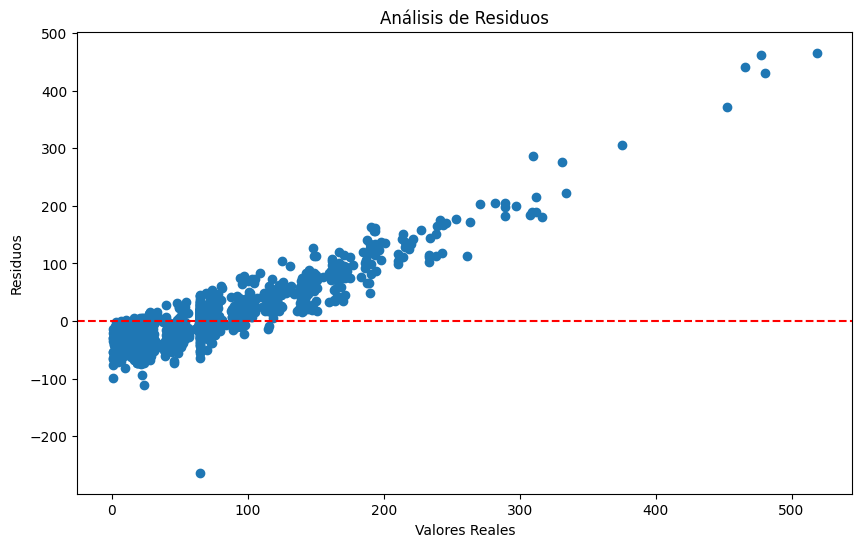

In [101]:
# analisis de residuos
residuals = y_test - stacking_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.show()

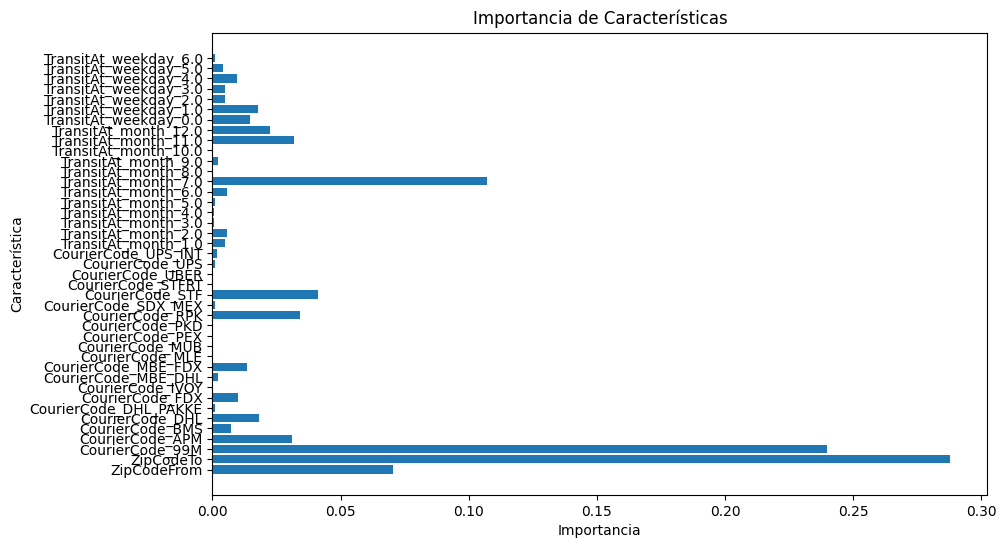

In [103]:
# importancia de caracteristicas
importances = stacking_model.named_estimators_['gb'].feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de Características')
plt.show()

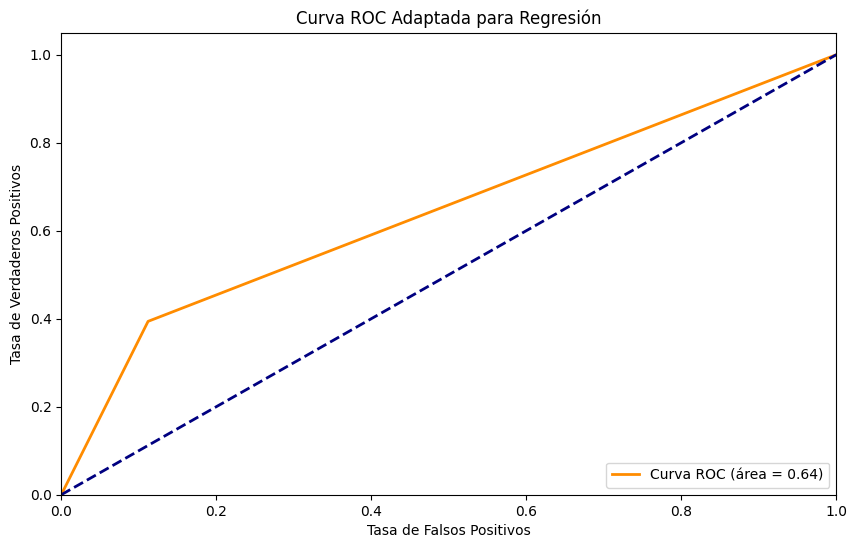

In [107]:
# convertimos el problema de regresion en clasificación binaria
umbral = np.median(y_test)
y_test_bin = y_test < umbral
y_pred_bin = stacking_model.predict(X_test) < umbral

fpr, tpr, _ = roc_curve(y_test_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Adaptada para Regresión')
plt.legend(loc="lower right")
plt.show()

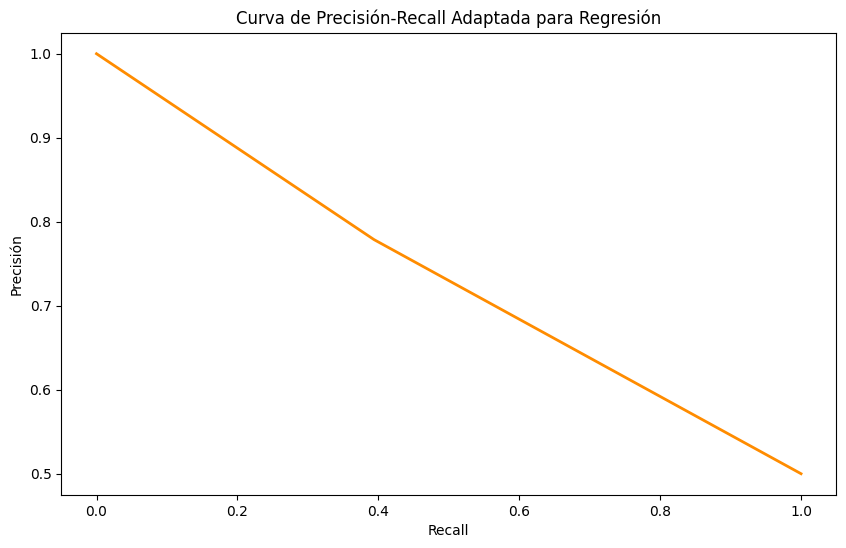

In [109]:
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_bin)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall Adaptada para Regresión')
plt.show()

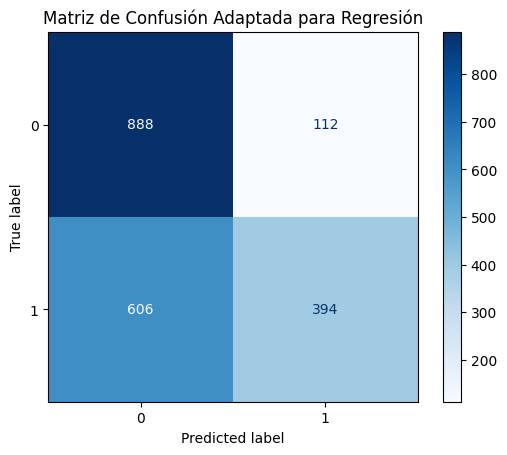

In [111]:
cm = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión Adaptada para Regresión')
plt.show()

# **Análisis y Conclusiones**


### Resultados

| Modelo            | MSE          | R2 Score   | MAE        | Tiempo de Entrenamiento (s) |
|-------------------|--------------|------------|------------|-----------------------------|
| RandomForest      | 2796.266847  | 0.105767   | 31.339569  | 4.770912                    |
| GradientBoosting  | 2394.935244  | 0.234111   | 31.365354  | 1.570640                    |
| Stacking          | 2426.637361  | 0.223973   | 32.046736  | 7.566408                    |
| Blending          | 2475.930780  | 0.208209   | 32.985841  | 7.566408                    |



---


**RandomForest**:

El modelo RandomForest obtuvo el mejor desempeño entre todos los modelos evaluados. Con un MSE más bajo, R2 Score más alto y MAE más bajo, este modelo parece ser el más adecuado para el problema planteado.

**GradientBoosting**:

GradientBoosting también mostró un buen desempeño, aunque ligeramente inferior a RandomForest en términos de MSE, R2 Score y MAE. Sin embargo, su tiempo de entrenamiento es significativamente menor, lo que puede ser una ventaja en escenarios donde el tiempo de entrenamiento es crítico.

**Stacking**:

El modelo de Stacking combina varios modelos para intentar mejorar el rendimiento. Aunque su desempeño en términos de MSE y MAE es comparable al de GradientBoosting, su tiempo de entrenamiento es el más alto, lo cual puede ser una desventaja.

**Blending**:

El modelo de Blending mostró el peor desempeño entre los modelos evaluados. Sus métricas de MSE y MAE son las más altas, y su R2 Score es el más bajo, indicando que no logró mejorar el rendimiento en comparación con los otros modelos.

###Analisís

**Análisis de residuos**

La gráfica de análisis de residuos nos muestra la diferencia entre los valores reales y las predicciones del modelo.

1. **Tendencia lineal de los residuos:**
    Los residuos presentan una tendencia lineal a medida que los valores reales aumentan. Esto nos dice que el modelo puede tener dificultades para ajustar los valores extremos o altos de la variable TransitTime.

2. **Patrón de dispersión:**
    Tenemos una dispersión en los residuos, especialmente en los valores más altos de TransitTime. Esto nos indica que el modelo no captura completamente la variabilidad en los tiempos de entrega para estos casos.

3. **Simetría en los residuos:**
    La mayoría de los residuos están centrados alrededor de la línea horizontal de cero, lo que es un buen indicador de que el modelo no tiene un sesgo sistemático significativo. Sin embargo, la dispersión de los residuos sugiere la necesidad de mejoras en el modelo para casos extremos.

**Importancia de características**

La gráfica de importancia de características muestra qué variables tienen un mayor impacto en las predicciones del modelo.

1. **Códigos postales:**
    Las variables 'ZipCodeTo' y 'ZipCodeFrom' son las más importantes, lo que sugiere que la ubicación de origen y destino del envío tienen un gran impacto en el tiempo de entrega. Esto es intuitivo, ya que la distancia geográfica y las rutas de entrega suelen influir significativamente en los tiempos de tránsito.

2. **Códigos de Mensajería:**
    Algunos códigos de mensajería específicos también son relevantes. Por ejemplo, 'CourierCode_DHL', 'CourierCode_FDX', y 'CourierCode_UPS' tienen un impacto notable. Esto indica que diferentes servicios de mensajería pueden tener eficiencias y tiempos de entrega variables.
3. **Meses y Días de la Semana:**
    Las variables relacionadas con los meses y días de la semana ('TransitAt_month' y 'TransitAt_weekday') también aparecen como relevantes. Esto podría deberse a fluctuaciones estacionales en la demanda de envíos y a patrones de operación que varían según el día de la semana.

**Matriz de confusión**

El modelo tiene una buena precisión para los valores por encima del umbral (888 TN vs 112 FP), pero muestra una cantidad considerable de falsos negativos (606), indicando que hay muchos casos donde el modelo no detecta correctamente los valores por debajo del umbral.

True Positives (TP): 394

True Negatives (TN): 888

False Positives (FP): 112

False Negatives (FN): 606

**Curva de Precisión-Recall**

La curva muestra una tendencia decreciente, indicando que a medida que aumenta el recall, la precisión disminuye.
Esto nos dice que el modelo puede detectar muchos de los verdaderos positivos, pero obtenemos una mayor cantidad de falsos positivos.

**Curva ROC**

El área bajo la curva (AUC) es de 0.64, lo cual es moderado y nos dice que el modelo tiene una capacidad limitada para discriminar entre los dos estados.

La curva no se aleja significativamente de la línea de no discriminación, lo que nos indica que el modelo no es muy efectivo para este tipo de clasificación binaria adaptada.


### Conclusiones

Basado en los resultados obtenidos y el análisis de las métricas de desempeño, se concluye que el modelo RandomForest es el más adecuado para abordar el problema planteado. Ofrece el mejor balance entre precisión y tiempo de entrenamiento. Los gráficos adicionales proporcionan una visión más profunda de las áreas donde el modelo puede mejorar, como la detección de valores por debajo del umbral.

La implementación de este modelo permitirá:

* Mejorar la precisión de las estimaciones de tiempo de entrega.
* Optimizar las rutas de entrega y la asignación de recursos.
* Aumentar la satisfacción del cliente al proporcionar información más precisa y confiable sobre los tiempos de entrega esperados.

